# TP 4 : Explicabilité et LIME

Dans ce TP, nous allons explorer une méthode conçue pour interprêter les résultats en inférence d'un modèle de type boite noire tel qu'un réseau de neurones profond ou un ensemble d'arbres de décisions. 

## LOCAL INTERPRETABLE MODEL-AGNOSTIC EXPLANATIONS (LIME)

La méthode LIME consiste à approcher localement un classifieur boite noire par un classifieur plus simple et surtout interprétable. Ici par interprétable, nous entendons, dont les prises de décisions s'appuient sur des éléments compréhensible pour un humain. Les classifieur chargés d'approcher des modèles plus puissant se basent donc sur des réprésentations interprétables et non des représentations apprises. Par exemple, pour de la classification de texte, ces représentations peuvent être la présence ou abscence d'un mot et pour de la classification d'image la présence ou abscence de surpe-pixels (composantes connexes) dans l'image. 

LIME consiste donc à trouver un classifieur intérptétable $g \in \mathcal G$ donnant une approximation locale d'un classifieur $f$ non interprétable. Ici $\mathcal G$ désigne l'ensemble des modèles interpétables *e.g.* des modèles linéaires ou des arbres de décision. On suppose que $f$ s'applique à des tenseurs $x \in \mathbb R^d$ (texte, image, ...) de dimension $d$. $g$ prend en entrée un vecteur binaire $x'=\{0,1\}^{d'}$, de dimension $d'$, indicant la présence ou l'absence d'un élément constitutif et interprétable d'une entrée de $f$. Dans le cas où $x$ est une image, de dimension $d=height \times width \times channels$ découpée en $d'$ super-pixels, $x'$ indique quels super-pixels sont fournis en entrée de $g$. Trouver $g$ passe par la résolution d'un problème minimilisation sous contrainte:

$$g = \underset{g\in\mathcal G}{\text{argmin }} \mathcal L(f,g,\pi_x) + \Omega(g),$$
avec $\Omega$ une fonction croissante de la complexité de $g$, $\mathcal L$ une loss pénalisant les écarts de prédiction entre $f$ et $g$, et $\pi_x$ un voisinage autour de $x$ réglant la pertinence du modèle interprétable par rapport à $f$.

## Explicabilité d'un classifieur de texte

Dans cette première partie, nous allons utiliser le package lime et s'en servir pour analyser un modèle de type random forest entraîné pour classifier du texte. Le jeu de données étudié est la base de corpus [20 news groups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) comprenant 18000 textes portant sur 20 sujets différents, divisés en deux sous sections. Pour nous simplifier la tâche, nous regarderons en particulier le sujets `religion` associé au deux sous-classes `christianity` et `atheism`.

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 7.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=6416c7a812e61aa135e4061912812bde9e542429789a3c39da0f63f009672a28
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

Apprenons à prensent un classifieur binaire de tye random forest pour distinguer les deux catégorie de texte.

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(n_estimators=500)

In [ ]:
pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

0.9241540256709451

Les performance de ce classifieur sur cet exemple sont très bonnes. Voyons à présent s'il est possible d'analyser ses prises de décision. Pour cela nous allons récupérer la prédiction associée à ce classifieur par la fonction `make_pipeline` de scikit learn. Le classifieur sera ensuite utilisée par LIME pour connaître la prédiction d'un texte recomposé en cachant certains mots. Nous prenons ici le texte associé à l'`id` 83 et nous choississons au plus 6 descripteurs binaires (abscence ou présence de mots)

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
c = make_pipeline(vectorizer, rf)
explainer = LimeTextExplainer(class_names=class_names)



idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])


Document id: 83
Probability(christian) = 0.466
True class: atheism


Le classifieur interprétable à bien retrouvé la bonne classe ici *ie* atheism. À présent, observons l'explicabilité associée aux différents mots utilisés pour construire  un voisinage à la donnée d'origine par masking:

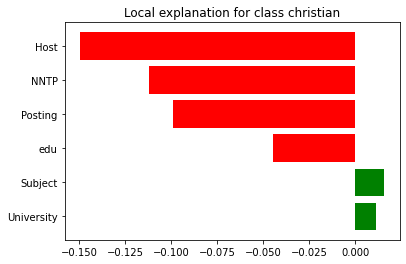

In [ ]:
fig = exp.as_pyplot_figure()

Ici, on voit que retirer le mot `Host` a tendance à faire pencher le classifieur vers la mauvaise classe *ie* chrstian. 

## Interpétabilité pour la classification d'image

Dans cette partie, nous allons construire nous même le voisinage et les poids associés d'une image tirée d'imagenet. Ce dataset auxiliaire sera utilisé pour apprendre un classifieur linéaire chargé d'analyser la dépendance du résultat de classification pour chaque différentes combinaisons de super-pixels

Commençons par définir quelques fonctions utilitaires pour traiter les images que nous allons générer.

In [ ]:
!wget cedric.cnam.fr/~rambourc/imagenet_class_index.json

In [ ]:
from sklearn.linear_model import Lasso
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.nn import functional as F
import os
import json

def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
  transf = get_input_transform()
  # unsqeeze converts single image to batch of 1
  return transf(img).unsqueeze(0)

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((170,224))
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Enfin, affichons l'image sur laquelle nous allons travailer dans cette partie.

In [ ]:
!wget cedric.cnam.fr/~rambourc/dogs.png

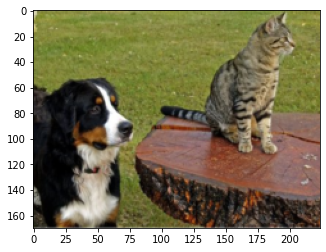

In [ ]:
from PIL import Image
f = open('dogs.png', 'rb')
img = Image.open(f).convert('RGB') 
img = pill_transf(img)
plt.imshow(img)

Et chargeons le modèle à analyser: un modèle de type inception pré-entraîné sur Imagenet.

In [ ]:
model = models.inception_v3(pretrained=True)

Tout d'abord, quel sont les cinq premières classes que le modèle reconnaît dans l'image ?

In [ ]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))


((0.93592995, 239, 'Bernese_mountain_dog'),
 (0.038447924, 241, 'EntleBucher'),
 (0.023756396, 240, 'Appenzeller'),
 (0.001818185, 238, 'Greater_Swiss_Mountain_dog'),
 (9.113342e-06, 214, 'Gordon_setter'))

Le modèle est particulièrment certain de la classe `239 Bernese_mountain_dog`.

Il est temps à présent de construire nos représentation interprétables sur lesquelles apprendre un classifieur linéaire. Pour cela, nous allons extraire des super-pixels de l'image. 

### Coding Task

Utiliser la méthode de Felzenszwalb pour découper l'image super-piels. On prendre les paramètres suivants: `scale=5, sigma=0.2, min_size=500`

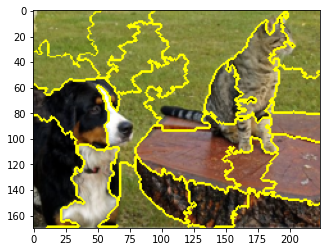

In [ ]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

segments = # your code here
plt.imshow(mark_boundaries(img, segments))

### Coding Task

Constituer un ensemble d'entraînement de `n = 1000` éléments. Chaque élément est généré de la façon suivante:

* Tirer au hasard le nombre de super-pixels (ou segments) dans l'image ainsi que leur état (masqué ou non) *ie* on récupère le vecteur $z$ de présence ou abscence des super-pixels : $z = \{0,1\}^{d'}$ 
* À partir de $z$, construire un masque à appliquer à l'image d'entré $x$ pour obtenir une image $x'$ proche de $x$.
* L'image masquée $x'$ est utilisée pour tester le réseau de neurones et recueillir la prédiction $y$ associé (utiliser la fonction `predict`).
* Le poid $w$ associé à $x'$ est calculé par
$$w = e^{\frac{||x - x'||_2^2}{\sigma^2}}$$ 
* Pour construire notre jeu de données, nous devons stocker chaque tuple {`z`}

In [ ]:
n = 1000
length = 3
sigma = 1e5
m = np.max(segments)

X = []
y = []
weights = []


for i in range(n):
  # Draw random number of selected super-pixel

  # Draw a random binary state for each of them

  # Compose a mask by shuting down the region corresponding to '0' super-pixels
  # and apply the masking to img 



  # Compute the prediction from the Inception_v3 model


  # Compute the weight



  X.append(z_prime)
  y.append(idx)
  weights.append(weight)
  print(i,'/',n)


Une fois le jeu de données annexe créer, il ne reste plus qu'à apprendre un classifieur linéaire permettant de retrouver les prédiction faite par le modèle sur des données proches de $x$. Pour que ce classifieur soit le plus interprêtable possible, on force ses coefficient à être parcimonieux. Le calcul du classifieur est fait avec l'approche [lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). 

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X,y,weights)

print(clf.coef_)

print(clf.intercept_)

[  -2.05650084   16.85117833  -43.9046898    13.57882643  -28.44777675
   19.31418238  -41.75241503   25.34414135  -19.05573965  -31.93848899
 -121.0570703   -19.53323822  -66.48000529  -24.79992228  -27.10057591
  -12.5077333   -58.99673522  -26.06633469  -21.7955709   -19.4172911 ]
522.0916051002041


Pour finir, parcourrons nos super-pixels pour analyser l'implication de chacun dans la prédiction du modèle.


Il est possible de parcourir l'ensemble des représentations et les classer des plus au moins siginificatif en terme de proximité de classe (on fera l'hypothèse que des classes proches sont sémantiquement proches) 

In [ ]:
from math import sqrt
c_pred = 239
score = []

for i in range(m):
  X = np.zeros((m,1))
  X[i] = 1
  c_simple = clf.predict(X.reshape(1, -1))
  score.append((i,round(c_simple[0]),sqrt((c_simple-c_pred)**2)))


score.sort(key=lambda x: (x[2]))

Vous pouvez observer à présent quelles régions ont été critiques dans la prise de décision du modèle:

In [ ]:
l = 0
idx_simple = score[l][1]
i = score[l][0]
#val = [i for i,x in enumerate(X[m]) if x==1]
mask = np.transpose(np.tile(segments==i,(3,1,1)),(1,2,0))
img_simple = pill_transf(img)*mask
plt.imshow(img_simple)
test_pred = batch_predict([img_simple])
idx = test_pred.squeeze().argmax()
print('Prédiction du modèle Inception_v3 ', idx , ' : ' , idx2label[idx])
print('Prédiction du classifieur linéaire ', idx_simple , ' : ' , idx2label[round(idx_simple)])

### Coding Task

Un seul super-pixel peut être rop parcelaire pour bien analyser le modèle appliqué à cette image. Observer l'impact des configuration du jeu d'entraînement stockées dans `X`